In [53]:
import kaggle
import os
import numpy as np
import zipfile
import pandas as pd
import seaborn as sns
from sklearn.model_selection import RepeatedKFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,SCORERS
from math import sqrt

In [3]:
# Download data
COMPETITION_NAME = 'elo-merchant-category-recommendation'
DOWNLOAD_FILES = False
UNZIP_FILES = False

kaggle_api = kaggle.KaggleApi()
kaggle_api.authenticate()

if DOWNLOAD_FILES:
    kaggle_api.competition_download_files(competition=COMPETITION_NAME, path='data', quiet=False)

if UNZIP_FILES:
    for item in os.listdir('data',):
        if item.endswith('zip'):
            file_name = os.path.abspath('data/' + item)
            zip_ref = zipfile.ZipFile(file_name)
            zip_ref.extractall('data/')
            zip_ref.close()
            os.remove(file_name)

In [4]:
# Read data
merchants = pd.read_csv('data/merchants.csv')
new_trans = pd.read_csv('data/new_merchant_transactions.csv')
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')
hist_trans = pd.read_csv('data/historical_transactions.csv')

## Data manipulation

In [82]:
train['first_active_year'] = train.first_active_month.str[:4]
train['first_active_month_m'] = train.first_active_month.str[5:].astype('int')

test['first_active_year'] = test.first_active_month.str[:4]
test['first_active_month_m'] = test.first_active_month.str[5:].astype('int')

ValueError: cannot convert float NaN to integer

## Explore train

In [6]:
train.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target', 'first_active_year', 'first_active_month_m'],
      dtype='object')

In [7]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,first_active_year,first_active_month_m
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,2017,06
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,2017,01
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,2016,08
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,2017,09
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,2017,11


In [104]:
test.iloc[11578]

first_active_month                  NaN
card_id                 C_ID_c27b4f80f7
feature_1                             5
feature_2                             2
feature_3                             1
first_active_year                   NaN
first_active_month_m                NaN
Name: 11578, dtype: object

In [103]:
test[test.isnull().any(axis=1)]

,first_active_month,card_id,feature_1,feature_2,feature_3,first_active_year,first_active_month_m
11578,NaN,C_ID_c27b4f80f7,5,2,1,NaN,NaN


#### target

In [8]:
train.target.describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

In [9]:
train.groupby(pd.cut(train.target,[-40,-1,0,1,40])).agg('size')

target
(-40, -1]    45742
(-1, 0]      58566
(0, 1]       56709
(1, 40]      40900
dtype: int64

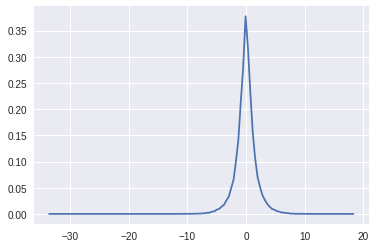

In [10]:
ax = sns.distplot(train[['target']], hist=False,rug = False)

Is normally distributed, half of data is between -1 and 1

#### first_active_month

In [71]:
print(train.first_active_month.min())
print(train.first_active_month.max())

TypeError: '<=' not supported between instances of 'str' and 'float'

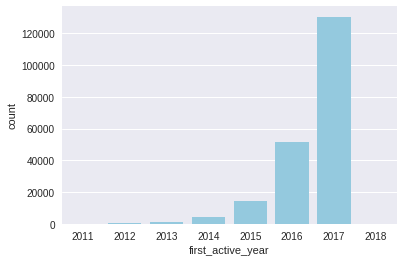

In [12]:
sns.countplot(x='first_active_year', data=train, color='skyblue')

[(-2.5, 2.5)]

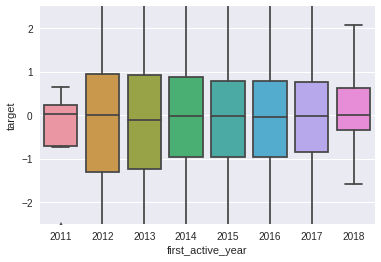

In [13]:
ax = sns.boxplot(x='first_active_year',y='target',data=train,orient='v')
ax.axes.set(ylim=(-2.5,2.5))

#### first_active_month_m

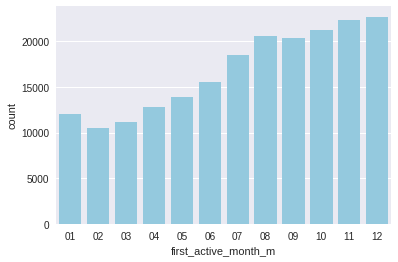

In [14]:
sns.countplot(x='first_active_month_m', data=train, color='skyblue')

In [15]:
year_months = train.groupby(['first_active_year','first_active_month_m']).size()
year_months.groupby('first_active_year').apply(lambda x: 100*x/x.sum()).groupby('first_active_month_m').mean()

first_active_month_m
01    19.471427
02     3.731123
03     4.763369
04     6.154659
05     7.960435
06     7.462820
07     9.419159
08    10.438816
09    10.586543
10    10.746234
11    22.075000
12    13.905195
dtype: float64

#### feature_1

In [16]:
temp = train.groupby('feature_1').size().reset_index(name='count')
temp['proportion'] = temp['count']/temp['count'].sum()
temp

,feature_1,count,proportion
0,1,12037,0.059614
1,2,55797,0.276336
2,3,73573,0.364372
3,4,19885,0.098481
4,5,40625,0.201197


[(-10, 10)]

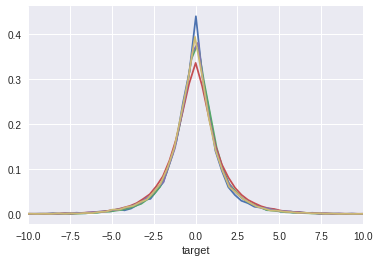

In [17]:
sns.distplot(train[train.feature_1==1].target, hist=False)
sns.distplot(train[train.feature_1==2].target, hist=False)
sns.distplot(train[train.feature_1==3].target, hist=False)
sns.distplot(train[train.feature_1==4].target, hist=False)
sns.distplot(train[train.feature_1==5].target, hist=False).set(xlim=[-10,10])

In [18]:
train.groupby('feature_1').target.agg('describe')

,count,mean,std,min,25%,50%,75%,max
feature_1,,,,,,,,
1,12037.0,-0.315476,3.407106,-33.219281,-0.810411,-0.011003,0.666923,15.011358
2,55797.0,-0.350452,3.756032,-33.219281,-0.806444,0.000000,0.768908,13.592223
3,73573.0,-0.377533,3.834499,-33.219281,-0.956521,-0.036539,0.837927,15.606405
4,19885.0,-0.404652,3.817954,-33.219281,-0.856211,0.000000,0.728345,9.665204
5,40625.0,-0.499879,4.134833,-33.219281,-0.895946,-0.056208,0.692869,17.965068


#### feature_2

In [19]:
temp = train.groupby('feature_2').target.agg('describe').reset_index()
temp['count_proportion'] = temp['count']/sum(temp['count'])
temp

,feature_2,count,mean,std,min,25%,50%,75%,max,count_proportion
0,1,89242.0,-0.398675,3.890548,-33.219281,-0.822850,-0.002394,0.738072,17.965068,0.441974
1,2,74839.0,-0.332899,3.567683,-33.219281,-0.946076,-0.045086,0.799371,15.606405,0.370642
2,3,37836.0,-0.501889,4.269270,-33.219281,-0.902546,-0.033784,0.766570,13.350895,0.187384


#### feature_3

In [20]:
train.groupby('feature_3').target.agg('describe').reset_index()

,feature_3,count,mean,std,min,25%,50%,75%,max
0,0,87719.0,-0.357939,3.724459,-33.219281,-0.817775,0.000000,0.745114,15.011358
1,1,114198.0,-0.421057,3.944379,-33.219281,-0.934403,-0.044637,0.783653,17.965068


### Build first model

In [21]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=11)

In [55]:
rfr = RandomForestRegressor(random_state=11,n_estimators=100)
rfr_params = {
    'max_depth':[2,4,6]
}

In [62]:
clf = GridSearchCV(estimator = rfr,
                      param_grid = rfr_params,
                      scoring = 'neg_mean_squared_error',
                      n_jobs=4,
                      iid=False,
                      cv=rkf,
                      return_train_score=True,
                      verbose=3)
clf.fit(X = train.drop(['target','card_id','first_active_month'],axis=1),
        y = train.target)

Fitting 15 folds for each of 3 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   59.5s
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x7fb9c9f3b518>,
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=11, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [2, 3, 6]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=3)

In [63]:
clf.cv_results_

{'mean_fit_time': array([ 6.33247094, 10.4370574 , 14.74076826]),
 'std_fit_time': array([0.54338666, 1.08644411, 1.79560375]),
 'mean_score_time': array([0.22100445, 0.31771334, 0.3720455 ]),
 'std_score_time': array([0.04456084, 0.05646123, 0.05957885]),
 'param_max_depth': masked_array(data=[2, 3, 6],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 2}, {'max_depth': 3}, {'max_depth': 6}],
 'split0_test_score': array([-15.2742004 , -15.26571787, -15.26037691]),
 'split1_test_score': array([-14.53871073, -14.5331521 , -14.53623975]),
 'split2_test_score': array([-15.0945061 , -15.08784301, -15.09040686]),
 'split3_test_score': array([-14.51232886, -14.50621835, -14.50893051]),
 'split4_test_score': array([-14.42422365, -14.41282729, -14.41646178]),
 'split5_test_score': array([-15.53731143, -15.52539256, -15.51102186]),
 'split6_test_score': array([-14.42960066, -14.42233888, -14.42622007]),
 'split7_test_score': 

In [64]:
clf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=11, verbose=0, warm_start=False)

In [67]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


#### Fit best estimator model to test set

In [70]:
clf.best_estimator_.predict(test.drop(['card_id','first_active_month'],axis=1))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').